In [63]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
# Transforms defined below after imports

In [66]:
!pip install timm medmnist scikit-learn matplotlib seaborn


In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from medmnist import PneumoniaMNIST
from medmnist import INFO


In [68]:
BATCH_SIZE=16
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # PneumoniaMNIST is grayscale; replicate to 3ch for model
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])



In [69]:
info = INFO['pneumoniamnist']
DataClass = PneumoniaMNIST

train_data = DataClass(split='train', download=True)
val_data   = DataClass(split='val', download=True)
test_data  = DataClass(split='test', download=True)


In [70]:
train_data.transform = train_transform
val_data.transform   = val_test_transform
test_data.transform  = val_test_transform

In [71]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)


In [72]:
MSCViT_CONFIGS = {
    "MSCViT-T": {
        "stem_channels": 16,
        "stages": [
            {"C": 32,  "P": 3, "R": 4},
            {"C": 64,  "P": 3, "R": 3},
            {"C": 128, "P": 5, "R": 2},
            {"C": 256, "P": 5, "R": 1},
        ],
    },
    "MSCViT-XS": {
        "stem_channels": 24,
        "stages": [
            {"C": 48,  "P": 3, "R": 4},
            {"C": 96,  "P": 3, "R": 3},
            {"C": 192, "P": 5, "R": 2},
            {"C": 384, "P": 5, "R": 1},
        ],
    },
    "MSCViT-S": {
        "stem_channels": 32,
        "stages": [
            {"C": 64,  "P": 3, "R": 4},
            {"C": 128, "P": 3, "R": 3},
            {"C": 256, "P": 5, "R": 2},
            {"C": 512, "P": 5, "R": 1},
        ],
    },
}
import torch
import torch.nn as nn

class ConvStem(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.stem = nn.Sequential(
            # First conv: downsample
            nn.Conv2d(3, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            # Repeat conv (×2) with stride = 1
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.stem(x)

class DWConv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dw = nn.Conv2d(dim, dim, 3, padding=1, groups=dim, bias=False)
        self.pw = nn.Conv2d(dim, dim, 1, bias=False)
        self.bn = nn.BatchNorm2d(dim)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.pw(self.dw(x))))

class LFE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = DWConv(dim)

    def forward(self, x):
        return self.conv(x)

class ChannelMixer(nn.Module):
    def __init__(self, dim, expansion=2):
        super().__init__()
        hidden = dim * expansion
        self.fc1 = nn.Conv2d(dim, hidden, 1, bias=False)
        self.act = nn.GELU()
        self.fc2 = nn.Conv2d(hidden, dim, 1, bias=False)
        self.bn = nn.BatchNorm2d(dim)

    def forward(self, x):
        return self.bn(self.fc2(self.act(self.fc1(x))))

class MSCBlock(nn.Module):
    def __init__(self, dim, attn_depth):
        super().__init__()

        self.lfe = LFE(dim)

        self.mixers = nn.ModuleList([
            ChannelMixer(dim)
            for _ in range(attn_depth)
        ])

    def forward(self, x):
        x = x + self.lfe(x)
        for m in self.mixers:
            x = x + m(x)
        return x

class Stage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, attn_depth):
        super().__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.blocks = nn.ModuleList([
            MSCBlock(out_channels, attn_depth)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        x = self.downsample(x)
        for blk in self.blocks:
            x = blk(x)
        return x
class MSCViT(nn.Module):
    def __init__(self, variant="MSCViT-T", num_classes=1000, global_pool="avg"):
        super().__init__()

        cfg = MSCViT_CONFIGS[variant]
        self.__class__.__name__ = variant

        self.stem = ConvStem(cfg["stem_channels"])

        in_ch = cfg["stem_channels"]
        self.stages = nn.ModuleList()

        for s in cfg["stages"]:
            self.stages.append(
                Stage(in_ch, s["C"], s["P"], s["R"])
            )
            in_ch = s["C"]

        self.head = nn.Linear(in_ch, num_classes) if num_classes > 0 else nn.Identity()
        self.global_pool = global_pool

    def forward(self, x):
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)

        x = x.mean((2, 3)) if self.global_pool == "avg" else x.amax((2, 3))
        return self.head(x)
from torchinfo import summary
import torch

image_size = 224           # Standard starting resolution
patch_size = 16            # Balanced for detail vs. compute
in_channels = 3            # Colored images
num_classes = 2            # PneumoniaMNIST: binary classification (Normal vs Pneumonia)

# Medical imaging / Kaggle dataset
model = MSCViT("MSCViT-T", num_classes=2)  # PneumoniaMNIST is binary: 0=Normal, 1=Pneumonia
model.to(device)

summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=("input_size", "output_size", "num_params"),
)
print("Model output: 2 classes (Normal=0, Pneumonia=1)")

Model output: 2 classes (Normal=0, Pneumonia=1)


In [73]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    num_classes = y_pred.shape[1]  # Fixed: use actual num_classes from model output
  # Replace the tn/fp/fn/tp block with:
    specificities = []
    sensitivities = []
    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - tp - fn - fp
        specificities.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        sensitivities.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    specificity = np.mean(specificities)
    sensitivity = np.mean(sensitivities)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [74]:
# Hyperparameters
num_epochs       = 25
initial_lr       = 1e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [75]:
num_classes=2  # PneumoniaMNIST is binary

In [76]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device).squeeze(1).long()  # MedMNIST returns (N,1); squeeze to (N,)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    
    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(training_metrics_line)
    
    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
    
    # Validation loop
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device).squeeze(1).long()  # squeeze (N,1) -> (N,)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    
    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(validation_metrics_line)
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
    # Step the scheduler to decay the learning rate by 0.995
    scheduler.step()

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 148/148 [00:17<00:00,  8.55it/s]


Metrics - loss: 0.2142, accuracy: 0.9136, precision: 0.9136, recall: 0.9136, f1_score: 0.9136, specificity: 0.8875, sensitivity: 0.8875, mcc: 0.7743, auc: 0.9640


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.15it/s]


Metrics - loss: 0.2449, accuracy: 0.9046, precision: 0.9154, recall: 0.9046, f1_score: 0.8966, specificity: 0.8148, sensitivity: 0.8148, mcc: 0.7469, auc: 0.9810


Training Model - Epoch [2/25]: 100%|██████████| 148/148 [00:16<00:00,  8.84it/s]


Metrics - loss: 0.1173, accuracy: 0.9535, precision: 0.9534, recall: 0.9535, f1_score: 0.9535, specificity: 0.9386, sensitivity: 0.9386, mcc: 0.8783, auc: 0.9884


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.46it/s]


Metrics - loss: 0.1713, accuracy: 0.9427, precision: 0.9484, recall: 0.9427, f1_score: 0.9440, specificity: 0.9493, sensitivity: 0.9493, mcc: 0.8611, auc: 0.9901


Training Model - Epoch [3/25]: 100%|██████████| 148/148 [00:16<00:00,  8.86it/s]


Metrics - loss: 0.0941, accuracy: 0.9643, precision: 0.9643, recall: 0.9643, f1_score: 0.9643, specificity: 0.9526, sensitivity: 0.9526, mcc: 0.9066, auc: 0.9921


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.74it/s]


Metrics - loss: 0.1107, accuracy: 0.9408, precision: 0.9406, recall: 0.9408, f1_score: 0.9397, specificity: 0.9045, sensitivity: 0.9045, mcc: 0.8421, auc: 0.9915


Training Model - Epoch [4/25]: 100%|██████████| 148/148 [00:16<00:00,  8.86it/s]


Metrics - loss: 0.0588, accuracy: 0.9760, precision: 0.9759, recall: 0.9760, f1_score: 0.9760, specificity: 0.9669, sensitivity: 0.9669, mcc: 0.9371, auc: 0.9970


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.88it/s]


Metrics - loss: 0.1315, accuracy: 0.9561, precision: 0.9579, recall: 0.9561, f1_score: 0.9548, specificity: 0.9172, sensitivity: 0.9172, mcc: 0.8845, auc: 0.9915


Training Model - Epoch [5/25]: 100%|██████████| 148/148 [00:16<00:00,  8.88it/s]


Metrics - loss: 0.0373, accuracy: 0.9860, precision: 0.9860, recall: 0.9860, f1_score: 0.9860, specificity: 0.9817, sensitivity: 0.9817, mcc: 0.9634, auc: 0.9988


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 19.10it/s]


Metrics - loss: 0.1201, accuracy: 0.9523, precision: 0.9540, recall: 0.9523, f1_score: 0.9528, specificity: 0.9485, sensitivity: 0.9485, mcc: 0.8788, auc: 0.9922


Training Model - Epoch [6/25]: 100%|██████████| 148/148 [00:16<00:00,  8.82it/s]


Metrics - loss: 0.0524, accuracy: 0.9796, precision: 0.9796, recall: 0.9796, f1_score: 0.9796, specificity: 0.9726, sensitivity: 0.9726, mcc: 0.9466, auc: 0.9977


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.60it/s]


Metrics - loss: 0.2949, accuracy: 0.9198, precision: 0.9375, recall: 0.9198, f1_score: 0.9228, specificity: 0.9436, sensitivity: 0.9436, mcc: 0.8227, auc: 0.9909


Training Model - Epoch [7/25]: 100%|██████████| 148/148 [00:16<00:00,  8.71it/s]


Metrics - loss: 0.0417, accuracy: 0.9843, precision: 0.9843, recall: 0.9843, f1_score: 0.9843, specificity: 0.9792, sensitivity: 0.9792, mcc: 0.9589, auc: 0.9985


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.72it/s]


Metrics - loss: 0.1843, accuracy: 0.9370, precision: 0.9451, recall: 0.9370, f1_score: 0.9386, specificity: 0.9479, sensitivity: 0.9479, mcc: 0.8507, auc: 0.9907


Training Model - Epoch [8/25]: 100%|██████████| 148/148 [00:16<00:00,  8.79it/s]


Metrics - loss: 0.0271, accuracy: 0.9883, precision: 0.9883, recall: 0.9883, f1_score: 0.9883, specificity: 0.9846, sensitivity: 0.9846, mcc: 0.9695, auc: 0.9994


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.66it/s]


Metrics - loss: 0.2070, accuracy: 0.9408, precision: 0.9470, recall: 0.9408, f1_score: 0.9422, specificity: 0.9481, sensitivity: 0.9481, mcc: 0.8571, auc: 0.9934


Training Model - Epoch [9/25]: 100%|██████████| 148/148 [00:16<00:00,  8.81it/s]


Metrics - loss: 0.0259, accuracy: 0.9894, precision: 0.9894, recall: 0.9894, f1_score: 0.9894, specificity: 0.9856, sensitivity: 0.9856, mcc: 0.9722, auc: 0.9995


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.87it/s]


Metrics - loss: 0.1576, accuracy: 0.9523, precision: 0.9533, recall: 0.9523, f1_score: 0.9511, specificity: 0.9147, sensitivity: 0.9147, mcc: 0.8736, auc: 0.9919


Training Model - Epoch [10/25]: 100%|██████████| 148/148 [00:16<00:00,  8.87it/s]


Metrics - loss: 0.0111, accuracy: 0.9958, precision: 0.9958, recall: 0.9958, f1_score: 0.9958, specificity: 0.9942, sensitivity: 0.9942, mcc: 0.9889, auc: 0.9999


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.71it/s]


Metrics - loss: 0.1363, accuracy: 0.9580, precision: 0.9578, recall: 0.9580, f1_score: 0.9576, specificity: 0.9354, sensitivity: 0.9354, mcc: 0.8888, auc: 0.9920


Training Model - Epoch [11/25]: 100%|██████████| 148/148 [00:16<00:00,  8.89it/s]


Metrics - loss: 0.0270, accuracy: 0.9900, precision: 0.9900, recall: 0.9900, f1_score: 0.9900, specificity: 0.9863, sensitivity: 0.9863, mcc: 0.9739, auc: 0.9993


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.62it/s]


Metrics - loss: 0.1247, accuracy: 0.9580, precision: 0.9578, recall: 0.9580, f1_score: 0.9579, specificity: 0.9427, sensitivity: 0.9427, mcc: 0.8898, auc: 0.9894


Training Model - Epoch [12/25]: 100%|██████████| 148/148 [00:16<00:00,  8.91it/s]


Metrics - loss: 0.0254, accuracy: 0.9909, precision: 0.9909, recall: 0.9909, f1_score: 0.9909, specificity: 0.9882, sensitivity: 0.9882, mcc: 0.9761, auc: 0.9994


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.35it/s]


Metrics - loss: 0.4342, accuracy: 0.8740, precision: 0.8923, recall: 0.8740, f1_score: 0.8586, specificity: 0.7556, sensitivity: 0.7556, mcc: 0.6610, auc: 0.9948


Training Model - Epoch [13/25]: 100%|██████████| 148/148 [00:16<00:00,  8.89it/s]


Metrics - loss: 0.0266, accuracy: 0.9915, precision: 0.9915, recall: 0.9915, f1_score: 0.9915, specificity: 0.9884, sensitivity: 0.9884, mcc: 0.9778, auc: 0.9994


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.83it/s]


Metrics - loss: 0.1650, accuracy: 0.9580, precision: 0.9586, recall: 0.9580, f1_score: 0.9582, specificity: 0.9500, sensitivity: 0.9500, mcc: 0.8915, auc: 0.9836


Training Model - Epoch [14/25]: 100%|██████████| 148/148 [00:16<00:00,  8.91it/s]


Metrics - loss: 0.0285, accuracy: 0.9887, precision: 0.9887, recall: 0.9887, f1_score: 0.9887, specificity: 0.9854, sensitivity: 0.9854, mcc: 0.9706, auc: 0.9993


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.57it/s]


Metrics - loss: 0.1288, accuracy: 0.9599, precision: 0.9597, recall: 0.9599, f1_score: 0.9597, specificity: 0.9416, sensitivity: 0.9416, mcc: 0.8942, auc: 0.9933


Training Model - Epoch [15/25]: 100%|██████████| 148/148 [00:16<00:00,  8.73it/s]


Metrics - loss: 0.0089, accuracy: 0.9975, precision: 0.9975, recall: 0.9975, f1_score: 0.9975, specificity: 0.9967, sensitivity: 0.9967, mcc: 0.9933, auc: 0.9999


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.90it/s]


Metrics - loss: 0.1854, accuracy: 0.9485, precision: 0.9497, recall: 0.9485, f1_score: 0.9489, specificity: 0.9411, sensitivity: 0.9411, mcc: 0.8681, auc: 0.9911


Training Model - Epoch [16/25]: 100%|██████████| 148/148 [00:16<00:00,  8.90it/s]


Metrics - loss: 0.0111, accuracy: 0.9968, precision: 0.9968, recall: 0.9968, f1_score: 0.9968, specificity: 0.9965, sensitivity: 0.9965, mcc: 0.9917, auc: 0.9999


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.19it/s]


Metrics - loss: 0.1244, accuracy: 0.9561, precision: 0.9568, recall: 0.9561, f1_score: 0.9564, specificity: 0.9487, sensitivity: 0.9487, mcc: 0.8869, auc: 0.9940


Training Model - Epoch [17/25]: 100%|██████████| 148/148 [00:16<00:00,  8.91it/s]


Metrics - loss: 0.0098, accuracy: 0.9966, precision: 0.9966, recall: 0.9966, f1_score: 0.9966, specificity: 0.9953, sensitivity: 0.9953, mcc: 0.9911, auc: 0.9999


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.83it/s]


Metrics - loss: 0.1475, accuracy: 0.9580, precision: 0.9578, recall: 0.9580, f1_score: 0.9579, specificity: 0.9427, sensitivity: 0.9427, mcc: 0.8898, auc: 0.9940


Training Model - Epoch [18/25]: 100%|██████████| 148/148 [00:16<00:00,  8.90it/s]


Metrics - loss: 0.0033, accuracy: 0.9989, precision: 0.9989, recall: 0.9989, f1_score: 0.9989, specificity: 0.9990, sensitivity: 0.9990, mcc: 0.9972, auc: 1.0000


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.80it/s]


Metrics - loss: 0.1291, accuracy: 0.9676, precision: 0.9674, recall: 0.9676, f1_score: 0.9674, specificity: 0.9540, sensitivity: 0.9540, mcc: 0.9147, auc: 0.9941


Training Model - Epoch [19/25]: 100%|██████████| 148/148 [00:16<00:00,  8.91it/s]


Metrics - loss: 0.0070, accuracy: 0.9966, precision: 0.9966, recall: 0.9966, f1_score: 0.9966, specificity: 0.9950, sensitivity: 0.9950, mcc: 0.9911, auc: 1.0000


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.94it/s]


Metrics - loss: 0.1663, accuracy: 0.9637, precision: 0.9648, recall: 0.9637, f1_score: 0.9640, specificity: 0.9611, sensitivity: 0.9611, mcc: 0.9073, auc: 0.9903


Training Model - Epoch [20/25]: 100%|██████████| 148/148 [00:16<00:00,  8.88it/s]


Metrics - loss: 0.0067, accuracy: 0.9975, precision: 0.9975, recall: 0.9975, f1_score: 0.9975, specificity: 0.9964, sensitivity: 0.9964, mcc: 0.9933, auc: 1.0000


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.86it/s]


Metrics - loss: 0.1736, accuracy: 0.9523, precision: 0.9519, recall: 0.9523, f1_score: 0.9519, specificity: 0.9292, sensitivity: 0.9292, mcc: 0.8737, auc: 0.9891


Training Model - Epoch [21/25]: 100%|██████████| 148/148 [00:16<00:00,  8.90it/s]


Metrics - loss: 0.0059, accuracy: 0.9989, precision: 0.9989, recall: 0.9989, f1_score: 0.9989, specificity: 0.9990, sensitivity: 0.9990, mcc: 0.9972, auc: 1.0000


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.64it/s]


Metrics - loss: 0.1797, accuracy: 0.9580, precision: 0.9610, recall: 0.9580, f1_score: 0.9587, specificity: 0.9620, sensitivity: 0.9620, mcc: 0.8959, auc: 0.9935


Training Model - Epoch [22/25]: 100%|██████████| 148/148 [00:16<00:00,  8.87it/s]


Metrics - loss: 0.0057, accuracy: 0.9979, precision: 0.9979, recall: 0.9979, f1_score: 0.9979, specificity: 0.9975, sensitivity: 0.9975, mcc: 0.9945, auc: 1.0000


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.77it/s]


Metrics - loss: 0.1446, accuracy: 0.9656, precision: 0.9655, recall: 0.9656, f1_score: 0.9656, specificity: 0.9527, sensitivity: 0.9527, mcc: 0.9098, auc: 0.9927


Training Model - Epoch [23/25]: 100%|██████████| 148/148 [00:16<00:00,  8.89it/s]


Metrics - loss: 0.0044, accuracy: 0.9987, precision: 0.9987, recall: 0.9987, f1_score: 0.9987, specificity: 0.9983, sensitivity: 0.9983, mcc: 0.9967, auc: 1.0000


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.64it/s]


Metrics - loss: 0.2010, accuracy: 0.9466, precision: 0.9461, recall: 0.9466, f1_score: 0.9459, specificity: 0.9181, sensitivity: 0.9181, mcc: 0.8580, auc: 0.9910


Training Model - Epoch [24/25]: 100%|██████████| 148/148 [00:16<00:00,  8.90it/s]


Metrics - loss: 0.0019, accuracy: 0.9998, precision: 0.9998, recall: 0.9998, f1_score: 0.9998, specificity: 0.9999, sensitivity: 0.9999, mcc: 0.9994, auc: 1.0000


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.78it/s]


Metrics - loss: 0.1627, accuracy: 0.9618, precision: 0.9623, recall: 0.9618, f1_score: 0.9620, specificity: 0.9549, sensitivity: 0.9549, mcc: 0.9014, auc: 0.9926


Training Model - Epoch [25/25]: 100%|██████████| 148/148 [00:16<00:00,  8.91it/s]


Metrics - loss: 0.0038, accuracy: 0.9987, precision: 0.9987, recall: 0.9987, f1_score: 0.9987, specificity: 0.9983, sensitivity: 0.9983, mcc: 0.9967, auc: 1.0000


Validating Model: 100%|██████████| 17/17 [00:00<00:00, 18.71it/s]

Metrics - loss: 0.1426, accuracy: 0.9618, precision: 0.9618, recall: 0.9618, f1_score: 0.9618, specificity: 0.9501, sensitivity: 0.9501, mcc: 0.9002, auc: 0.9930
Total Training Time: 0:06:58.164003
Total Validation Time: 0:00:22.795040
Average Training Time per Epoch: 0:00:16.726560
Average Validation Time per Epoch: 0:00:00.911802


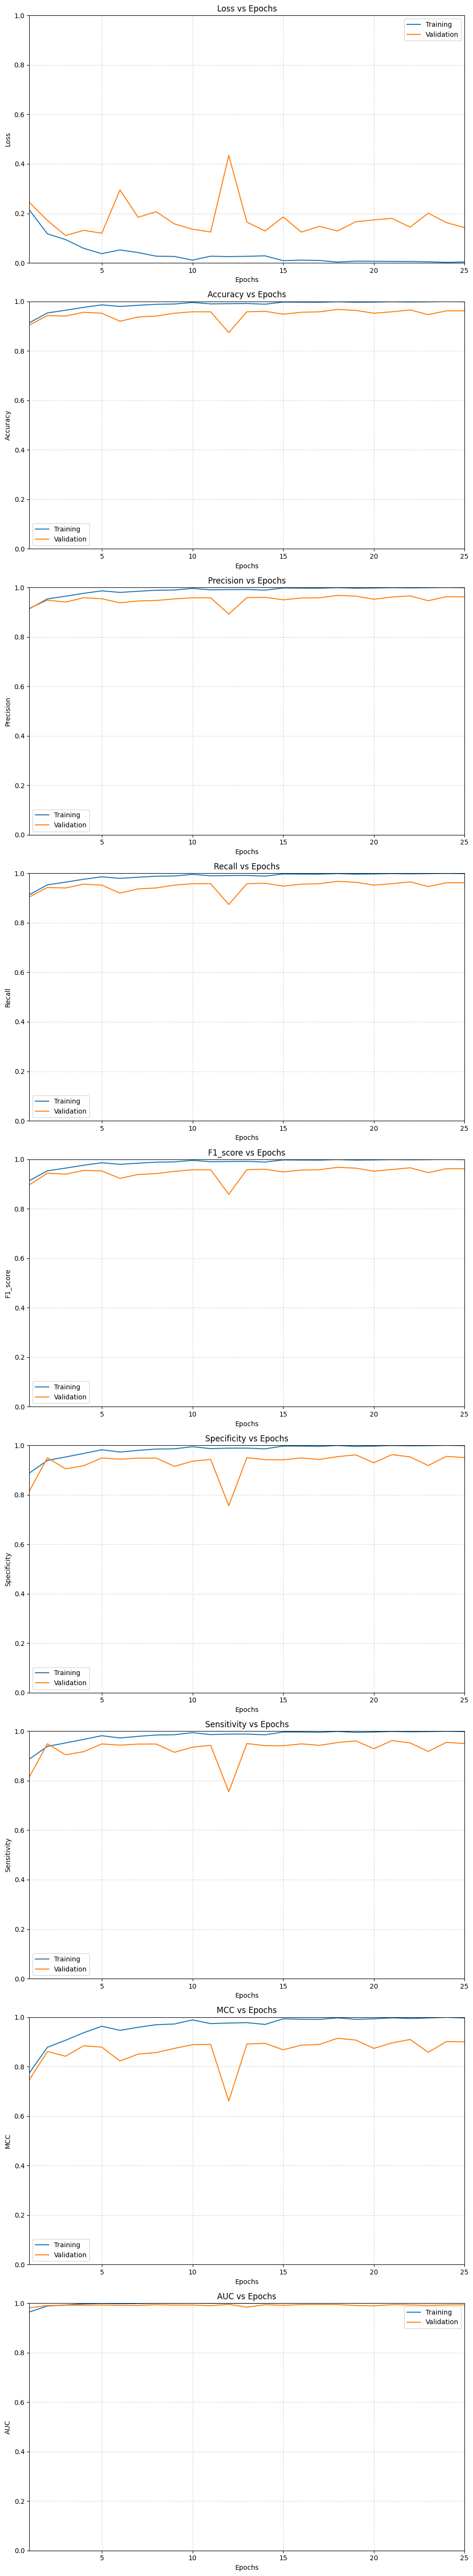

In [77]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [78]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device).squeeze(1).long()  # squeeze (N,1) -> (N,)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 20/20 [00:01<00:00, 17.87it/s]

Metrics - loss: 1.1728, accuracy: 0.8333, precision: 0.8643, recall: 0.8333, f1_score: 0.8202, specificity: 0.7795, sensitivity: 0.7795, mcc: 0.6590, auc: 0.9528


In [79]:
classes = ['Normal', 'Pneumonia']  # PneumoniaMNIST binary classes
